In [44]:
%load_ext autoreload
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
%autoreload
from src.xes.load_xes import load_raw_xes
from src.xes.xes_file import XesFile
from src.xes.print_xes_info import PrintXesInfo

In [4]:
xes = XesFile.read("data/Activities of daily living of several individuals_1_all/data/activitylog_uci_detailed_weekends.xes/activitylog_uci_detailed_weekends.xes")

In [7]:
PrintXesInfo.s_print_info(xes)

Traces: 10, events: 488
Events: Average: 48.8, Min: 28, Max: 70

4 unique attributes in events:
           Attribute  Count Presence
        concept:name    487    99.8%
lifecycle:transition    487    99.8%
      time:timestamp    487    99.8%
          watchingtv    487    99.8%

"time:timestamp": 99.8% presence
average:      2012-08-16 19:56:35.178278912+00:00
min:          2011-12-03 00:47:02+00:00
max:          2012-12-03 00:03:12+00:00
average span: 0 days 23:03:01.600000

"concept:name": 99.8% presence, 15 different values, top 5:
washing (88), watchingtv (74), toilet (70), grooming (54), outdoors (32)

"lifecycle:transition": 99.8% presence, 2 different values, top 2:
start (244), complete (244)

"watchingtv": 99.8% presence, 15 different values, top 5:
washing (88), watchingtv (74), toilet (70), grooming (54), outdoors (32)


In [8]:
df = xes.traces[0].df

In [11]:
sum(xes.df["concept:name"] != xes.df["watchingtv"])

0

In [32]:
event_sequence_dict = {}
lifecycle_transition_first_entry_name = "start"

start_df = df[df["lifecycle:transition"] == lifecycle_transition_first_entry_name]

# start_df

for index, series in start_df.iterrows():
    current_concept_name = series["concept:name"]

    events_after_current = start_df.loc[index+1:]

    if len(events_after_current) == 0: continue

    next_event = events_after_current.iloc[0]
    next_event_concept_name = next_event["concept:name"]

    # next_event = start_df[start_df["concept:name"] != series["concept:name"]].loc[index+1:]

    # print(next_event)

    if not current_concept_name in event_sequence_dict:
        event_sequence_dict[current_concept_name] = {}

    if not next_event_concept_name in event_sequence_dict[current_concept_name]:
        event_sequence_dict[current_concept_name][next_event_concept_name] = 0

    event_sequence_dict[current_concept_name][next_event_concept_name] += 1

    print(f"{index}: {current_concept_name} -> {next_event_concept_name}")


0: Start -> washing
2: washing -> toilet
4: toilet -> washing
5: washing -> sleeping
8: sleeping -> toilet
10: toilet -> prepareBreakfast
12: prepareBreakfast -> eatingBreakfast
14: eatingBreakfast -> shower
16: shower -> washing
18: washing -> grooming
20: grooming -> washing
22: washing -> grooming
24: grooming -> outdoors
26: outdoors -> washing
28: washing -> grooming
30: grooming -> watchingtv
32: watchingtv -> outdoors
34: outdoors -> toilet
36: toilet -> washing
37: washing -> toilet
39: toilet -> watchingtv
42: watchingtv -> snack
44: snack -> toilet
46: toilet -> washing
48: washing -> grooming
50: grooming -> washing
52: washing -> grooming
54: grooming -> outdoors
56: outdoors -> End


In [28]:
start_df.iloc[2]

concept:name                               toilet
lifecycle:transition                        start
time:timestamp          2012-11-17 01:31:05+00:00
watchingtv                                 toilet
Name: 4, dtype: object

In [33]:
event_sequence_dict

{'Start': {'washing': 1},
 'washing': {'toilet': 2, 'sleeping': 1, 'grooming': 5},
 'toilet': {'washing': 3, 'prepareBreakfast': 1, 'watchingtv': 1},
 'sleeping': {'toilet': 1},
 'prepareBreakfast': {'eatingBreakfast': 1},
 'eatingBreakfast': {'shower': 1},
 'shower': {'washing': 1},
 'grooming': {'washing': 2, 'outdoors': 2, 'watchingtv': 1},
 'outdoors': {'washing': 1, 'toilet': 1, 'End': 1},
 'watchingtv': {'outdoors': 1, 'snack': 1},
 'snack': {'toilet': 1}}

In [38]:
weights = np.array([10, 1, 1])
weights = weights / weights.sum()
np.random.choice(['a', 'b', 'c'], 20, True, weights)

array(['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'b',
       'a', 'a', 'c', 'a', 'a', 'a', 'a'], dtype='<U1')

In [35]:
np.array([10, 1, 1])

AttributeError: 'numpy.ndarray' object has no attribute 'normalize'

In [46]:
def choices_using_numpy(weights: dict[str, float], size: int = 1):
    values = [key for key in weights.keys()]
    np_weights = np.array([weight for weight in weights.values()])
    np_weights = np_weights / np_weights.sum()
    return np.random.choice(values, size=size, replace=True, p=np_weights)


<BarContainer object of 3 artists>

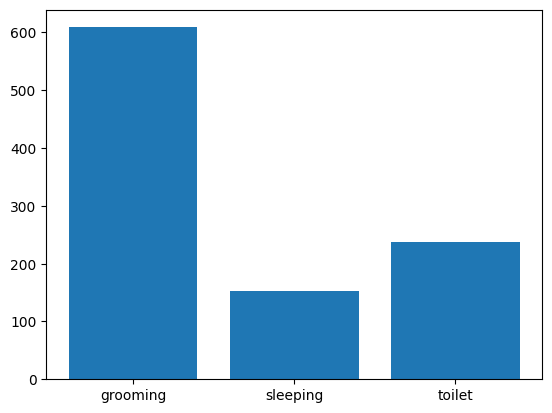

In [50]:
data = choices_using_numpy(event_sequence_dict["washing"], 1000)
x = np.unique(data)
y = [sum(data == key) for key in x]
plt.bar(x, y)

In [51]:
import networkx as nx

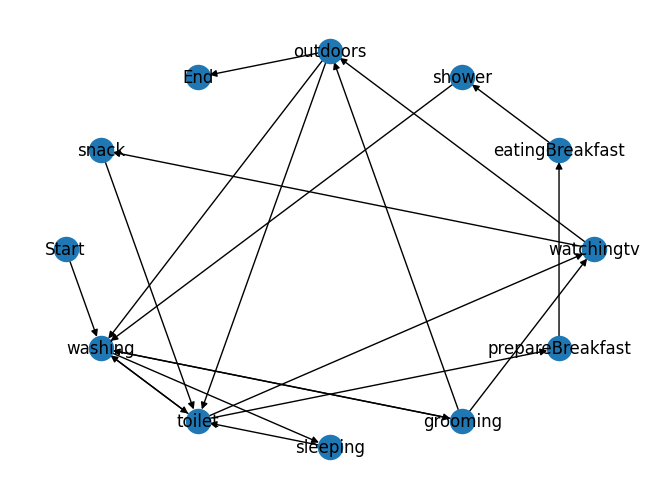

In [62]:
edges = [(source, destination, event_sequence_dict[source][destination])
         for source in event_sequence_dict.keys()
         for destination in event_sequence_dict[source].keys()]
DG = nx.DiGraph()
DG.add_weighted_edges_from(edges)
nx.draw_shell(DG, with_labels=True)
# event_sequence_dict

{('Start',
  'washing'): Text(-0.28259120049035624, -0.08244123925428572, "{'weight': 1}"),
 ('washing',
  'toilet'): Text(-0.0867082196201962, 0.09580092813773732, "{'weight': 2}"),
 ('washing',
  'sleeping'): Text(-0.2510157852029478, 0.1353716933028717, "{'weight': 1}"),
 ('washing',
  'grooming'): Text(-0.033364530678127266, -0.12755054677243835, "{'weight': 5}"),
 ('toilet',
  'washing'): Text(-0.0867082196201962, 0.09580092813773732, "{'weight': 3}"),
 ('toilet',
  'prepareBreakfast'): Text(-0.006496540285587486, 0.40472111675028927, "{'weight': 1}"),
 ('toilet',
  'watchingtv'): Text(-0.1233831709339266, 0.13381356499825953, "{'weight': 1}"),
 ('sleeping',
  'toilet'): Text(-0.23975952673566248, 0.2627367816427171, "{'weight': 1}"),
 ('grooming',
  'washing'): Text(-0.033364530678127266, -0.12755054677243835, "{'weight': 2}"),
 ('grooming',
  'outdoors'): Text(0.1525086995016788, -0.2942610194362811, "{'weight': 2}"),
 ('grooming',
  'watchingtv'): Text(-0.07003948199185767, -0.

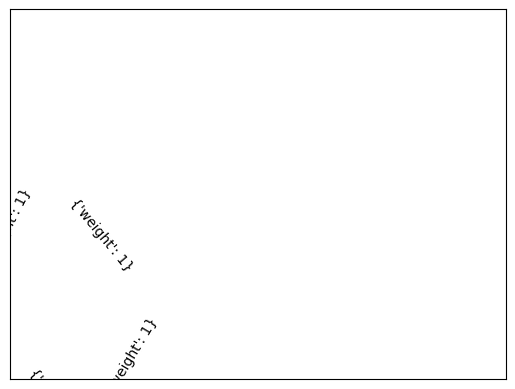

In [65]:
nx.draw_networkx_edge_labels(DG, pos=nx.spring_layout(DG))